In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pythreejs import *
from IPython.display import display
import lorm
from nfft import nfft
import disc.energy_curveling_so3

In [36]:
def compute_quaternions(point_coords_9d):
    point_coords_4d = np.empty([point_coords_9d.shape[0],4])
    for i,p in enumerate(point_coords_9d):
        point_coords_4d[i,:] = lorm.manif.SO3.compute_quaternion_representation(p)
    return point_coords_4d

def compute_stereographicprojection(point_coords_4d):
    point_coords_3d = np.empty([point_coords_4d.shape[0],3])
    for i,p in enumerate(point_coords_4d):
        point_coords_3d[i,:] = lorm.manif.Sphere3.compute_stereographicprojection(p)
    return point_coords_3d

In [37]:
# Fourier coefficients of mu
# int_0^1 legendre_p_n(x) dx
int_pn = np.array([1., 0.5, 0., -0.125, 0., 0.0625, 0., -0.0390625, 0., 0.0273438, 0., -0.0205078, 0., 0.0161133, 0., -0.013092, 0., 0.01091, 0., -0.00927353, 0., 0.00800896, 0., -0.00700784, 0., 0.00619924, 0., -0.00553504, 0., 0.00498153, 0., -0.00451451, 0., 0.00411617, 0., -0.00377316, 0., 0.00347528, 0., -0.00321463, 0., 0.00298502, 0., -0.00278149, 0., 0.00260009, 0., -0.00243759, 0., 0.00229133, 0., -0.00215914, 0., 0.00203919, 0., -0.00192994, 0., 0.00183012, 0., -0.00173861, 0., 0.00165449, 0., -0.00157693, 0.])

In [31]:
# initialize a curve on SO(3)
so3 = lorm.manif.SO3()
points = lorm.manif.ManifoldPointArrayParameterized(so3)
m = 64
points.coords = np.zeros([m,3,3])
local_coords = np.random.randn(m,3)
for i in range(m):
    local_coords[i,0] = np.sin(2*np.pi*i/m)+0.25*np.cos(6*np.pi*i/m)
    local_coords[i,1] = np.arccos(0.7)
    local_coords[i,2] = np.cos(2*np.pi*i/m)
points.local_coords = local_coords

In [41]:
# setup the energy
N = 4
m = points.coords.shape[0]
energy = disc.energy_curveling_so3.plan(m,N,0.0001,20)
for n in range(np.min((N+1,len(int_pn)))):
        energy._mu_hat[n,0,0] = int_pn[n]
energy._weights = np.real(energy._mu_hat[0,0,0])* np.ones([int(m),1],dtype=float) / int(m)

In [42]:
# setup the interactive rendering 
g1 = BufferGeometry(attributes={'position': BufferAttribute(compute_stereographicprojection(compute_quaternions(points.coords))
    , normalized=False) })
m1 = LineBasicMaterial(vertexColors='VertexColors', linewidth=3)
line1 = Line(g1,m1)

c = PerspectiveCamera(position=[0, 2, 2], up=[0, 2, 0],
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

scene = Scene(children=[line1, c, AmbientLight(color='#777777')])

renderer = Renderer(camera=c,
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])
renderer.width =400
renderer.height =400
display(renderer)

def update_points(p):
    g1.attributes['position'].array = compute_stereographicprojection(compute_quaternions(p.coords))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

In [43]:
# compute a local minimizer of the energy
method = lorm.optim.ConjugateGradientMethod(max_iter=50)
method.listener = update_points 
for i in range(3):
    points = method.run(energy,points)

Initial value: f[0] = 0.08877511808693618
f[1] = 0.019092011621315474
f[2] = 0.011372234096908337
f[3] = 0.00942989654952149
f[4] = 0.00738167864192447
f[5] = 0.006153611373465024
f[6] = 0.005386940485775741
f[7] = 0.004638626273671325
f[8] = 0.004119470034435126
f[9] = 0.0035492918916739196
f[10] = 0.003222733225995532
f[11] = 0.0030952454282859154
f[12] = 0.0029816985156228106
f[13] = 0.0028505910642509812
f[14] = 0.0027438996150661327
f[15] = 0.0026424114577000635
f[16] = 0.002586490867522803
f[17] = 0.0025221052422244048
f[18] = 0.002460843808590819
f[19] = 0.0023970911406321575
f[20] = 0.002356940673595339
f[21] = 0.0023364644731662396
f[22] = 0.002313682408797587
f[23] = 0.0022986033924264344
f[24] = 0.002283794389396358
f[25] = 0.002273884828326223
f[26] = 0.0022631635293935562
f[27] = 0.002250583673347255
f[28] = 0.002233736974542791
f[29] = 0.0022220770216587827
f[30] = 0.0022120523149569836
f[31] = 0.002197744989414264
f[32] = 0.0021803018478882136
f[33] = 0.00216870175622623

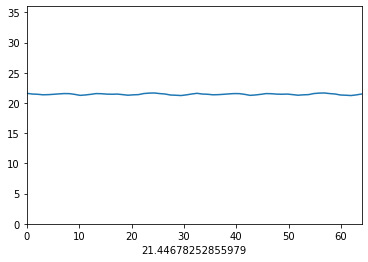

In [44]:
#%matplotlib notebook
fig = plt.figure()
bx = fig.add_subplot(111)
bx.axis(np.array([0,m,0.000,1.8*energy._L]))
bx.set_xlabel(np.sum(energy._eval_lengths(points.local_coords)))
distance = plt.Line2D(np.linspace(0,m,m),m*energy._eval_lengths(points.local_coords))
bx.add_line(distance)

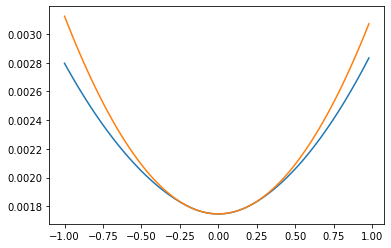

In [50]:
# test the quatradic approximation obtain from the gradient and the Hessian
v=energy.grad(points)
v.coords = 0.05*np.random.randn(m,9)
f,q, s = lorm.utils.eval_objective_function_with_quadratic_approximation(energy,v)
plt.plot(s,f,s,q)